In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 18 10:19:34 2021

@author: Valen
"""
#Hello

import sys
sys.path.insert(0, 'evoman')
from environment import Environment
from demo_controller import player_controller

# imports other libs
import time
import numpy as np
#from math import fabs,sqrt
import glob, os

# choose this for not using visuals and thus making experiments faster
headless = True
if headless:
    os.environ["SDL_VIDEODRIVER"] = "dummy"


experiment_name = 'individual_demo'
if not os.path.exists(experiment_name):
    os.makedirs(experiment_name)

n_hidden_neurons = 10

# initializes simulation in individual evolution mode, for single static enemy.
env = Environment(experiment_name=experiment_name,
                  enemies=[2],
                  playermode="ai",
                  player_controller=player_controller(n_hidden_neurons),
                  enemymode="static",
                  level=2,
                  speed="fastest")

# default environment fitness is assumed for experiment

env.state_to_log() # checks environment state


####   Optimization for controller solution (best genotype-weights for phenotype-network): Ganetic Algorihm    ###

ini = time.time()  # sets time marker


# genetic algorithm params

run_mode = 'train' # train or test

# number of weights for multilayer with 10 hidden neurons
n_vars = (env.get_num_sensors()+1)*n_hidden_neurons + (n_hidden_neurons+1)*5
print("Number of weights: " + str(n_vars))


# runs simulation
def simulation(env,x):
    f,p,e,t = env.play(pcont=x)
    return f

# evaluation
def evaluate(x):
    return np.array(list(map(lambda y: simulation(env,y), x)))

# DEAP - own code starts here 
from deap import base, creator
import random
from deap import tools
#maximizing fitness
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
#creator.create("Individual", list, fitness=creator.FitnessMax)
from array import array
creator.create("Individual", array, typecode="d",
               fitness=creator.FitnessMax, strategy=None)
creator.create("Strategy", array, typecode="d")

def initES(icls, scls, size, imin, imax, smin, smax):
    ind = icls(random.uniform(imin, imax) for _ in range(size))
    ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))
    return ind

IND_SIZE = n_vars
MIN_VALUE, MAX_VALUE = -1., 1.
MIN_STRAT, MAX_STRAT = -1., 1. 

toolbox = base.Toolbox()
toolbox.register("individual", initES, creator.Individual,
                 creator.Strategy, IND_SIZE, MIN_VALUE, MAX_VALUE, MIN_STRAT, 
                 MAX_STRAT)


#uniform = random.uniform(-1, 1)
toolbox.register("attribute", np.random.uniform, -1, 1)
#random.uniform(-1.,1.)
#toolbox.register("individual", tools.initRepeat, creator.Individual,
#                 toolbox.attribute, n= n_vars)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
#toolbox.register("population", tools.initRepeat, np.array([]), toolbox.individual)



toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutESLogNormal, c = 1, indpb=0.1)
toolbox.register("parentselection", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)
toolbox.register("survivalselection", tools.selBest)

#to compile statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)
logbook = tools.Logbook()


pop_size = 20

#test

def main():
    # create variables to later save the best individual
    best_ind = 1
    best_fit = -100
    
    
    pop = toolbox.population(n=pop_size)
    CXPB, MUTPB, NGEN = 0.7, 0.2, 10

    # Evaluate the entire population
    #fitnesses = map(toolbox.evaluate, np.array(pop))
    #for ind, fit in zip(pop, fitnesses):
    #    ind.fitness.values = fit
    for i in range(pop_size):
        fitness = toolbox.evaluate(np.array([pop[i]]))
        pop[i].fitness.values = fitness
        if fitness > best_fit:
            best_fit = fitness
            best_ind = pop[i]

    # show first random generation
    record = stats.compile(pop)
    print("Gen 0: ")
    print(record)
    

    for g in range(NGEN):
        # Select the next generation individuals - parent selection 
        parents = toolbox.parentselection(pop, (2*len(pop)))
        # Clone the selected individuals
        parents = list(map(toolbox.clone, parents))

        
        offspring = []
        # Apply crossover on the offspring
        
        #like this
        for parent1, parent2 in zip(parents[::2], parents[1::2]): 
            if random.random() < CXPB:
                child1, child2 = toolbox.mate(parent1, parent2)
                del child1.fitness.values
                del child2.fitness.values
                offspring.append(child1)
                offspring.append(child2)
        print(len(offspring)) 
        
        #or like this
# =============================================================================
#         for child1, child2 in zip(parents[::2], parents[1::2]):
#             if random.random() < CXPB:
#                 toolbox.mate(child1, child2)
#                 del child1.fitness.values
#                 del child2.fitness.values
# =============================================================================
                
        # mutation
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        #invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        #for i in range(len(invalid_ind)):
        #    invalid_ind[i].fitness.values = toolbox.evaluate(np.array([invalid_ind[i]]))
        for i in range(len(offspring)):
            fitness = toolbox.evaluate(np.array([offspring[i]]))
            offspring[i].fitness.values = fitness
            if fitness > best_fit:
                best_fit = fitness
                best_ind = offspring[i]
            
        
        survivedoffspring = toolbox.survivalselection(offspring, pop_size)
        
        # The population is entirely replaced by the offspring
        pop = survivedoffspring
        print(len(pop))
        
        record = stats.compile(pop)
        print("Gen : " + str(g+1))
        print(record)
        logbook.record(gen= (g +1), evals=30, **record)
        
    return best_ind


pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html

MESSAGE: Pygame initialized for simulation.

########## Simulation state - INI ###########

# solutions # : EMPTY 

# sensors # : 20

 ------  parameters ------  

# contact hurt (training agent) # : player

multiple mode: no

enemies list: 2

current enemy: 2

player mode: ai

enemy mode: static

level: 2

clock precision: low

inputs coded: no

random initialization: yes

expiration time: 3000

speed: fastest

load player: yes

load enemy: yes

sound: off

overture time: 100

logs: on

save logs: yes

########## Simulation state - END ###########
Number of weights: 265


In [2]:
best_individuals = []
for i in range(3):
    best_ind = main()
    best_individuals.append(best_ind)
    
print(logbook)


RUN: run status: enemy: 2; fitness: -5.805134968916488; player life: 0; enemy life: 100; time: 332

RUN: run status: enemy: 2; fitness: 21.194865031083513; player life: 0; enemy life: 70.0; time: 332

RUN: run status: enemy: 2; fitness: -5.768320995793772; player life: 0; enemy life: 100; time: 320

RUN: run status: enemy: 2; fitness: -5.814130531825066; player life: 0; enemy life: 100; time: 335

RUN: run status: enemy: 2; fitness: 12.779644174921675; player life: 0; enemy life: 80.0; time: 185

RUN: run status: enemy: 2; fitness: -5.805134968916488; player life: 0; enemy life: 100; time: 332

RUN: run status: enemy: 2; fitness: 92.11642023266131; player life: 78; enemy life: 0; time: 294

RUN: run status: enemy: 2; fitness: -5.8971538676367405; player life: 0; enemy life: 100; time: 364

RUN: run status: enemy: 2; fitness: -5.771441123130016; player life: 0; enemy life: 100; time: 321

RUN: run status: enemy: 2; fitness: -5.814130531825066; player life: 0; enemy life: 100; time: 335


RUN: run status: enemy: 2; fitness: 91.85873645484158; player life: 74; enemy life: 0; time: 255

RUN: run status: enemy: 2; fitness: -5.75890177387728; player life: 0; enemy life: 100; time: 317

RUN: run status: enemy: 2; fitness: -5.805134968916488; player life: 0; enemy life: 100; time: 332

RUN: run status: enemy: 2; fitness: 89.94375419465169; player life: 50; enemy life: 0; time: 157

RUN: run status: enemy: 2; fitness: -5.4510384535657; player life: 0; enemy life: 100; time: 233

RUN: run status: enemy: 2; fitness: 89.4371553697401; player life: 44; enemy life: 0; time: 143

RUN: run status: enemy: 2; fitness: -5.75890177387728; player life: 0; enemy life: 100; time: 317

RUN: run status: enemy: 2; fitness: 66.19486503108351; player life: 0; enemy life: 20.0; time: 332

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 91.57237888630937; player life: 72; enemy life: 0; time: 278

RUN: run statu


RUN: run status: enemy: 2; fitness: 91.57237888630937; player life: 72; enemy life: 0; time: 278

RUN: run status: enemy: 2; fitness: -5.8944028342648505; player life: 0; enemy life: 100; time: 363

RUN: run status: enemy: 2; fitness: 57.19486503108351; player life: 0; enemy life: 30.0; time: 332

RUN: run status: enemy: 2; fitness: -5.081404364984463; player life: 0; enemy life: 100; time: 161

RUN: run status: enemy: 2; fitness: -5.75890177387728; player life: 0; enemy life: 100; time: 317

RUN: run status: enemy: 2; fitness: 91.45873645484157; player life: 70; enemy life: 0; time: 255

RUN: run status: enemy: 2; fitness: 91.84317193830047; player life: 74; enemy life: 0; time: 259

RUN: run status: enemy: 2; fitness: -5.75890177387728; player life: 0; enemy life: 100; time: 317

RUN: run status: enemy: 2; fitness: 91.84317193830047; player life: 74; enemy life: 0; time: 259

RUN: run status: enemy: 2; fitness: 91.85873645484158; player life: 74; enemy life: 0; time: 255

RUN: run s


RUN: run status: enemy: 2; fitness: 90.76878821817864; player life: 64; enemy life: 0; time: 279

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 92.24317193830046; player life: 78; enemy life: 0; time: 259
20
Gen : 8
{'avg': array([91.97131857]), 'std': array([0.28662857]), 'min': array([91.57237889]), 'max': array([92.86728121])}
20

RUN: run status: enemy: 2; fitness: 91.93703951986404; player life: 76; enemy life: 0; time: 288

RUN: run status: enemy: 2; fitness: 91.85873645484158; player life: 74; enemy life: 0; time: 255

RUN: run status: enemy: 2; fitness: 91.57237888630937; player life: 72; enemy life: 0; time: 278

RUN: run status: enemy: 2; fitness: 91.84317193830047; player life: 74; enemy life: 0; time: 259

RUN: run status: enemy: 2; fitness: 91.45873645484157; player life: 70; enemy life: 0


RUN: run status: enemy: 2; fitness: -5.44673737166631; player life: 0; enemy life: 100; time: 232

RUN: run status: enemy: 2; fitness: -5.783825182329737; player life: 0; enemy life: 100; time: 325

RUN: run status: enemy: 2; fitness: -5.327876168789581; player life: 0; enemy life: 100; time: 206

RUN: run status: enemy: 2; fitness: -5.455321115357702; player life: 0; enemy life: 100; time: 234

RUN: run status: enemy: 2; fitness: 90.11859563501554; player life: 52; enemy life: 0; time: 161

RUN: run status: enemy: 2; fitness: -5.796057750765372; player life: 0; enemy life: 100; time: 329

RUN: run status: enemy: 2; fitness: 30.711732969305466; player life: 0; enemy life: 60.0; time: 198

RUN: run status: enemy: 2; fitness: -5.805134968916488; player life: 0; enemy life: 100; time: 332

RUN: run status: enemy: 2; fitness: 67.04417294239875; player life: 0; enemy life: 20.0; time: 142

RUN: run status: enemy: 2; fitness: -5.755742213586912; player life: 0; enemy life: 100; time: 316

R


RUN: run status: enemy: 2; fitness: 87.99605369405454; player life: 30; enemy life: 0; time: 149

RUN: run status: enemy: 2; fitness: 89.79605369405454; player life: 48; enemy life: 0; time: 149
20
Gen : 3
{'avg': array([89.6986314]), 'std': array([1.14650078]), 'min': array([87.79605369]), 'max': array([92.3630474])}
34

RUN: run status: enemy: 2; fitness: 90.31859563501554; player life: 54; enemy life: 0; time: 161

RUN: run status: enemy: 2; fitness: 66.77964417492167; player life: 0; enemy life: 20.0; time: 185

RUN: run status: enemy: 2; fitness: 66.77964417492167; player life: 0; enemy life: 20.0; time: 185

RUN: run status: enemy: 2; fitness: 89.44417294239875; player life: 44; enemy life: 0; time: 142

RUN: run status: enemy: 2; fitness: 89.97065437104557; player life: 54; enemy life: 0; time: 228

RUN: run status: enemy: 2; fitness: 87.99605369405454; player life: 30; enemy life: 0; time: 149

RUN: run status: enemy: 2; fitness: 90.76956207860756; player life: 58; enemy life:


RUN: run status: enemy: 2; fitness: 66.57065437104556; player life: 0; enemy life: 20.0; time: 228

RUN: run status: enemy: 2; fitness: 84.8124499851752; player life: 14; enemy life: 0; time: 726

RUN: run status: enemy: 2; fitness: 40.48914049348315; player life: 0; enemy life: 50.0; time: 91

RUN: run status: enemy: 2; fitness: 91.72188534076949; player life: 70; enemy life: 0; time: 196

RUN: run status: enemy: 2; fitness: 88.60956741322126; player life: 36; enemy life: 0; time: 147

RUN: run status: enemy: 2; fitness: 91.76878821817864; player life: 74; enemy life: 0; time: 279

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 65.81791509328337; player life: 0; enemy life: 20.0; time: 484

RUN: run status: enemy: 2; fitness: 91.85873645484158; player life: 74; enemy life: 0; time: 255

RUN: run status: enemy: 2; fitness: 39.53616819497439; player life: 0; enemy life: 50.0; time: 236

RUN: run stat


RUN: run status: enemy: 2; fitness: 91.77237888630937; player life: 74; enemy life: 0; time: 278

RUN: run status: enemy: 2; fitness: 91.85873645484158; player life: 74; enemy life: 0; time: 255

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 91.57237888630937; player life: 72; enemy life: 0; time: 278

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 91.77237888630937; player life: 74; enemy life: 0; time: 278

RUN: run status: enemy: 2; fitness: 91.77237888630937; player life: 74; enemy life: 0; time: 278

RUN: run status: enemy: 2; fitness: 91.76878821817864; player life: 74; enemy life: 0; time: 279

RUN: run status: enemy: 2; fitness: 84.63614447346788; player life: 12; enemy life: 0; time: 709

RUN: run status: enemy: 2; fitness: 75.12506926914797; player life: 0; enemy life: 10.0; time: 356

RUN: run status: 


RUN: run status: enemy: 2; fitness: 22.009567413221262; player life: 0; enemy life: 70.0; time: 147

RUN: run status: enemy: 2; fitness: -6.008813185442595; player life: 0; enemy life: 100; time: 407

RUN: run status: enemy: 2; fitness: 90.13740496697304; player life: 52; enemy life: 0; time: 158

RUN: run status: enemy: 2; fitness: 30.185869468174936; player life: 0; enemy life: 60.0; time: 335

RUN: run status: enemy: 2; fitness: 12.142066845516542; player life: 0; enemy life: 80.0; time: 350

RUN: run status: enemy: 2; fitness: -4.955827057601261; player life: 0; enemy life: 100; time: 142

RUN: run status: enemy: 2; fitness: -5.771441123130016; player life: 0; enemy life: 100; time: 321

RUN: run status: enemy: 2; fitness: 48.19486503108351; player life: 0; enemy life: 40.0; time: 332

RUN: run status: enemy: 2; fitness: -5.0106352940962555; player life: 0; enemy life: 100; time: 150

RUN: run status: enemy: 2; fitness: -5.814130531825066; player life: 0; enemy life: 100; time: 33


RUN: run status: enemy: 2; fitness: 12.701682633451963; player life: 0; enemy life: 80.0; time: 200

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 87.38506424239101; player life: 26; enemy life: 0; time: 184

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 91.57237888630937; player life: 72; enemy life: 0; time: 278

RUN: run status: enemy: 2; fitness: 12.62010264645954; player life: 0; enemy life: 80.0; time: 217

RUN: run status: enemy: 2; fitness: 91.85873645484158; player life: 74; enemy life: 0; time: 255

RUN: run status: enemy: 2; fitness: 91.37237888630936; player life: 70; enemy life: 0; time: 278

RUN: run status: enemy: 2; fitness: 21.89405452609942; player life: 0; enemy life: 70.0; time: 165

RUN: run sta


RUN: run status: enemy: 2; fitness: 30.681880006155783; player life: 0; enemy life: 60.0; time: 204

RUN: run status: enemy: 2; fitness: 91.85873645484158; player life: 74; enemy life: 0; time: 255

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 91.84317193830047; player life: 74; enemy life: 0; time: 259

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 75.19486503108351; player life: 0; enemy life: 10.0; time: 332

RUN: run status: enemy: 2; fitness: 91.85873645484158; player life: 74; enemy life: 0; time: 255

RUN: run status: enemy: 2; fitness: 91.85873645484158; player life: 74; enemy life: 0; time: 255

RUN: run status: enemy: 2; fitness: 91.57237888630937; player life: 72; enemy life: 0; time: 278

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run statu


RUN: run status: enemy: 2; fitness: 57.19486503108351; player life: 0; enemy life: 30.0; time: 332

RUN: run status: enemy: 2; fitness: 91.84317193830047; player life: 74; enemy life: 0; time: 259

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 91.85873645484158; player life: 74; enemy life: 0; time: 255

RUN: run status: enemy: 2; fitness: 91.84317193830047; player life: 74; enemy life: 0; time: 259
20
Gen : 9
{'avg': array([91.87264758]), 'std': array([0.08069419]), 'min': array([91.57237889]), 'max': array([91.93357331])}
24

RUN: run status: enemy: 2; fitness: 91.93357331188756; player life: 76; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 91.85873645484158; player life: 74; enemy life:

In [3]:
for indiv in best_individuals:
    #print(indiv)
    print(indiv.fitness.values)
    

(93.06728120673463,)
(92.64317193830047,)
(92.5001335721758,)


In [4]:
means = []
for indiv in best_individuals:
    fiveruns = []
    for i in range(5):
        fitness = toolbox.evaluate(np.array([indiv]))
        fiveruns.append(fitness)
    means.append(np.mean(fiveruns))
means
        
        
    


RUN: run status: enemy: 2; fitness: 75.1888590070233; player life: 0; enemy life: 10.0; time: 334

RUN: run status: enemy: 2; fitness: 66.18586946817493; player life: 0; enemy life: 20.0; time: 335

RUN: run status: enemy: 2; fitness: 66.18586946817493; player life: 0; enemy life: 20.0; time: 335

RUN: run status: enemy: 2; fitness: 92.09874178945526; player life: 76; enemy life: 0; time: 245

RUN: run status: enemy: 2; fitness: 93.06728120673463; player life: 84; enemy life: 0; time: 207

RUN: run status: enemy: 2; fitness: 91.85873645484158; player life: 74; enemy life: 0; time: 255

RUN: run status: enemy: 2; fitness: 92.64317193830047; player life: 82; enemy life: 0; time: 259

RUN: run status: enemy: 2; fitness: 91.85873645484158; player life: 74; enemy life: 0; time: 255

RUN: run status: enemy: 2; fitness: 91.57237888630937; player life: 72; enemy life: 0; time: 278

RUN: run status: enemy: 2; fitness: 92.53357331188757; player life: 82; enemy life: 0; time: 289

RUN: run statu

[78.54532418791261, 92.0933194092361, 92.44066440298782]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f979a6b2760>,
 'caps': [<matplotlib.lines.Line2D at 0x7f979a6b2e20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f979a6b2400>],
 'medians': [<matplotlib.lines.Line2D at 0x7f979a800520>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f979a800820>],
 'means': []}

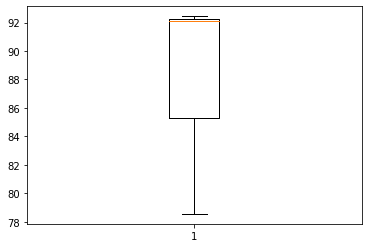

In [5]:
import matplotlib.pyplot as plt

plt.boxplot(means)

In [ ]:
# create variables to later save the best individual
best_ind = 1
best_fit = -100
    

pop = toolbox.population(n=pop_size)
CXPB, MUTPB, NGEN = 0.7, 0.2, 10

# Evaluate the entire population
#fitnesses = map(toolbox.evaluate, np.array(pop))
#for ind, fit in zip(pop, fitnesses):
#    ind.fitness.values = fit
for i in range(pop_size):
    fitness = toolbox.evaluate(np.array([pop[i]]))
    pop[i].fitness.values = fitness
    if fitness > best_fit:
        best_fit = fitness
        best_ind = pop[i]
        
print(best_ind.fitness.values)